# Introduction
This project involves classifying news sources based on one of 5 categories (business, entertainment, politics, sport, or tech).  The dataset is 2225 text articles.  This is an NLP task with unsupervised learning.

In [84]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from joblib import dump

# Exploratory Data Analysis
## Examining the Data
We will begin with an initial inspection of the data.  From this, we can see that it is a CSV of article IDs, text, and categories.  This is straight forward, and we can begin to consider ways to analyze the data.

In [53]:
training = pd.read_csv('learn-ai-bbc/BBC News Train.csv')
training.info()
training.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## Considerations for Cleaning the Data
In order to create contrast between the data, it may be worthwhile to remove common words such as "the", "is", and "and".  We will use the ENGLISH_STOP_WORDS to handle this.
As for other cleaning ideas, there is not much to do as it seems like the data is generally intact with no gaps.  It would be beneficial to remove punctuation and make everything lowercase, for simplicity sake.
Before we actually clean any data, lets just take alook at word frequency distribution as well as category distribution.

In [54]:
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = text.lower() # Convert text to lowercase
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(words)

training['cleaned_text'] = training['Text'].apply(clean_text)

print(training.info())
training.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ArticleId     1490 non-null   int64 
 1   Text          1490 non-null   object
 2   Category      1490 non-null   object
 3   cleaned_text  1490 non-null   object
dtypes: int64(1), object(3)
memory usage: 46.7+ KB
None


,ArticleId,Text,Category,cleaned_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses 168m payout eighteen enron direct...


Now, let's count the word frequency.

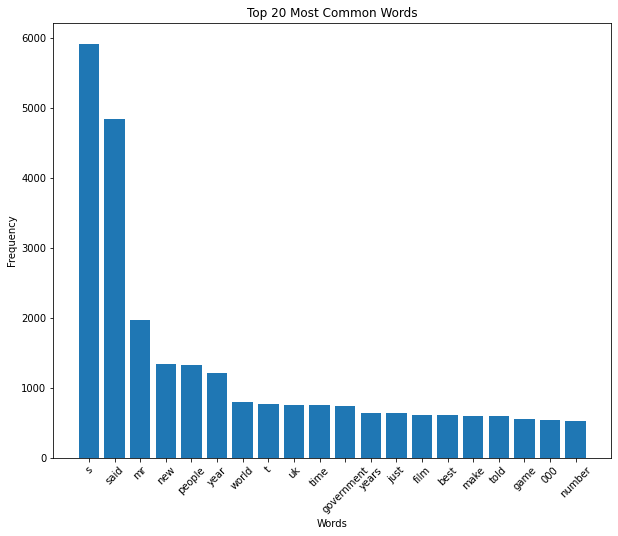

In [55]:
all_text = ' '.join(training['cleaned_text']) # Combine all cleaned text into one large string
word_counts = Counter(all_text.split())
most_common_words = word_counts.most_common(20)
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 8))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words')
plt.show()

## Additional Cleaning after EDA
Now we can see that past stop words, there are still some junk words to remove.  Particularly, mr, said, s, and t.  Beyong that, we will leave words in.


In [56]:
TO_REMOVE = ['mr', 'said', 's', 't']
def clean_text_additional(text):
    words = text.split()
    words = [word for word in words if word not in TO_REMOVE]
    return ' '.join(words)

training['cleaned_text_2'] = training['cleaned_text'].apply(clean_text_additional)

Now, lets view the frequency graph one more time.

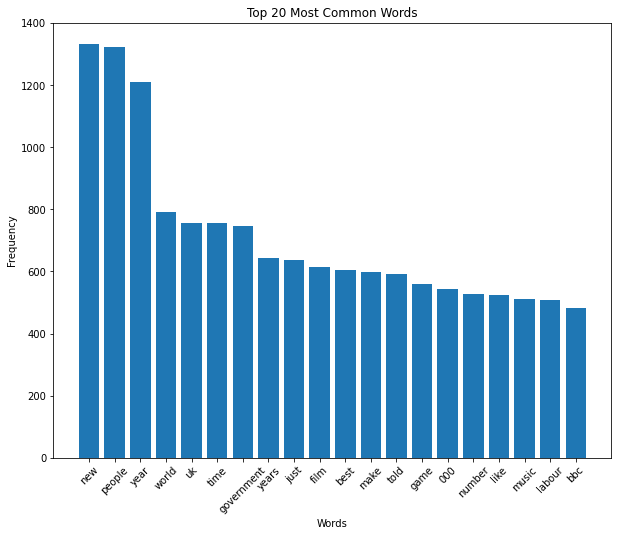

In [57]:
all_text = ' '.join(training['cleaned_text_2'])
word_counts = Counter(all_text.split())
most_common_words = word_counts.most_common(20)
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 8))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words')
plt.show()

## Additional Exploration
Now that we are done cleaning, we can look at other trends.  For example, do any categories typically have longer articles on average?  The answer is yes, tech articles tend to be longer.  While there isn't a ton of variation, this is something we will include for the model.

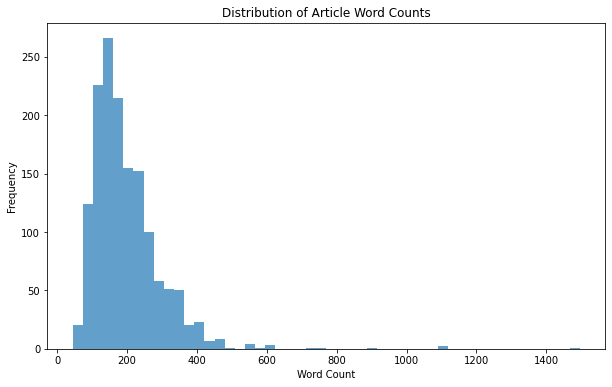

<Figure size 864x576 with 0 Axes>

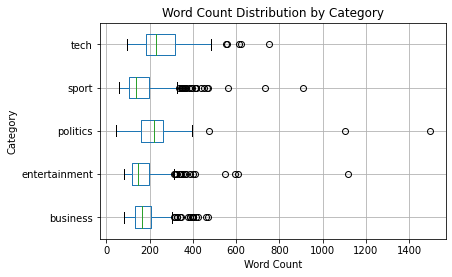

In [59]:
training['word_count'] = training['cleaned_text_2'].apply(lambda x: len(x.split()))

# Visualize the distribution of article lengths
plt.figure(figsize=(10, 6))
plt.hist(training['word_count'], bins=50, alpha=0.7)
plt.title('Distribution of Article Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
training.boxplot(column='word_count', by='Category', vert=False)
plt.xlabel('Word Count')
plt.title('Word Count Distribution by Category')
plt.suptitle('')
plt.show()

## N-Gram Analysis
N-Gram Analysis is a technique that can discover common combinations of words in the dataset.  This may help us generate trends between categories.  We will also store a top n-gram column for each article, which may give the model insights.  Since there are lots of 2-grams, we will focus on those for analysis, since 3-grams gets into a territory where not many share the same words.  For training feasibility, we will shorten the ngram column to simply one bigram phrase.

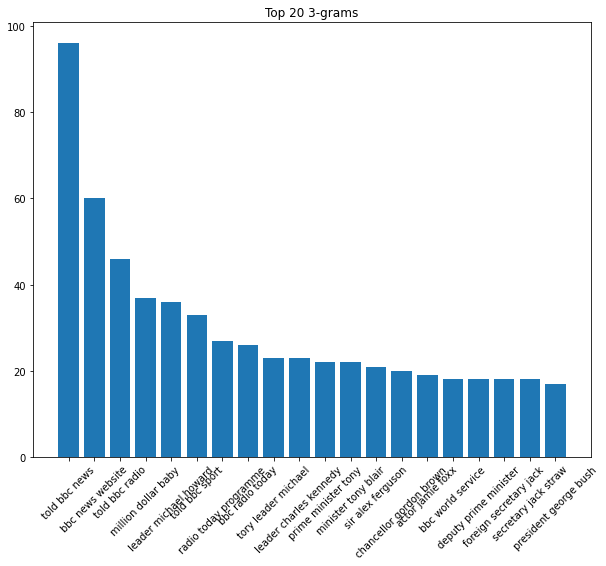

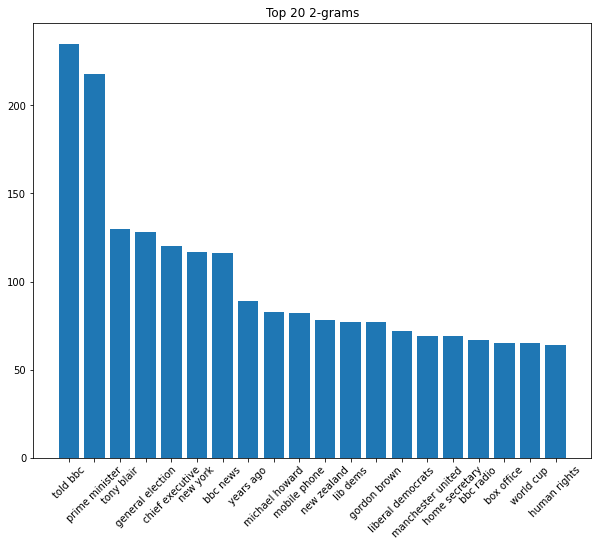

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   cleaned_text    1490 non-null   object
 4   cleaned_text_2  1490 non-null   object
 5   word_count      1490 non-null   int64 
 6   top_ngrams      1490 non-null   object
dtypes: int64(2), object(5)
memory usage: 81.6+ KB


,ArticleId,Text,Category,cleaned_text,cleaned_text_2,word_count,top_ngrams
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...,170,ms cooper
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,german business confidence slides german busin...,179,german business
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...,bbc poll indicates economic gloom citizens maj...,265,world economy
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,lifestyle governs mobile choice faster better ...,313,dr bjorn
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses 168m payout eighteen enron direct...,enron bosses 168m payout eighteen enron direct...,195,university california


In [60]:
# Function to find and plot top N-Grams
def plot_top_ngrams(corpus, n=None, ngrams=(1,1)):
    vec = CountVectorizer(ngram_range=ngrams, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_words_freq = words_freq[:n]
    top_words, top_freqs = zip(*top_words_freq)
    plt.figure(figsize=(10, 8))
    plt.bar(top_words, top_freqs)
    plt.xticks(rotation=45)
    plt.title(f"Top {n} {ngrams[1]}-grams")
    plt.show()

# Here, we will look at the top 20 trigrams and bigrams.
plot_top_ngrams(training['cleaned_text_2'], n=20, ngrams=(3,3))  # Top 20 trigrams
plot_top_ngrams(training['cleaned_text_2'], n=20, ngrams=(2,2))  # Top 20 bigrams


def get_top_ngrams(corpus, n=None, ngrams=(1,1), top_n=10):
    vec = CountVectorizer(ngram_range=ngrams, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n][0]

# Assuming 'cleaned_text' is the column with cleaned text data
training['top_ngrams'] = training['cleaned_text_2'].apply(lambda x: get_top_ngrams([x], ngrams=(2,2), top_n=1)[0])
training.info()
training.head(5)

# Building and Training Models
This will be an iterative process of tuning hyperparameters and testing.  For the base model, I elect to use NMF for matrix factorization.  I will also use TF-IDF to vectorize text.  The first model will be a "base", and then adjustments will be made to try and enhance performance.  We also will define a quick function to help comprehend the models and what words they are grouping together.

## Initial Results
Amazingly, we can tell by the associated topics in the matrix what each category is already.  The contrast is very stark!

In [66]:
def get_top_words_for_topics(H, feature_names, n_top_words=10):
    # Get top words for each topic
    top_words = {}
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_words[topic_idx] = top_features
    return top_words

In [68]:
tfidf_vectorizer = TfidfVectorizer(max_features=None)
tfidf_matrix = tfidf_vectorizer.fit_transform(training['cleaned_text_2'])

nmf_model = NMF(n_components=5, random_state=0)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

print('Fit ModeL:')
print(W)
print()
print('Components:')
print(H)
print()

feature_names = tfidf_vectorizer.get_feature_names_out()
top_words_per_topic = get_top_words_for_topics(H, feature_names, 10)
print(top_words_per_topic)

Fit ModeL:
[[0.00521321 0.00059814 0.00894074 0.00359239 0.05472939]
 [0.         0.         0.         0.         0.19740318]
 [0.01255113 0.02536979 0.02498637 0.00077715 0.12148098]
 ...
 [0.00324666 0.         0.00271884 0.01224143 0.14899918]
 [0.         0.         0.23444953 0.00317061 0.01682641]
 [0.00126896 0.         0.09998925 0.         0.        ]]

Components:
[[1.18904589e-02 2.07137752e-02 6.25643775e-04 ... 1.73386460e-02
  8.77996943e-04 1.03540055e-02]
 [6.71313158e-04 6.30589377e-02 3.09463632e-04 ... 0.00000000e+00
  1.25598119e-05 0.00000000e+00]
 [2.18075244e-04 8.51954394e-02 2.44874547e-04 ... 0.00000000e+00
  1.96507395e-04 0.00000000e+00]
 [0.00000000e+00 2.58577041e-02 0.00000000e+00 ... 0.00000000e+00
  1.12028071e-03 3.41752316e-04]
 [0.00000000e+00 1.08609698e-01 6.24149303e-05 ... 1.93068894e-04
  0.00000000e+00 0.00000000e+00]]

{0: ['england', 'game', 'win', 'wales', 'ireland', 'cup', 'players', 'play', 'team', 'france'], 1: ['labour', 'election', 'bl

From these, we can also define which topics are which categories.

In [70]:
topic_to_category = {
    0: 'sport',
    1: 'politics',
    2: 'tech',
    3: 'entertainment',
    4: 'business'
}

Now lets evaluate the base model on the training set's unfiltered data.  As we can see, 92% accuracy is pretty good for a first run,

In [74]:
# Getting the predictions out of the model
new_tfidf_matrix = tfidf_vectorizer.transform(training['Text'])
new_W = nmf_model.transform(new_tfidf_matrix)
dominant_topics = np.argmax(new_W, axis=1)
predicted_categories = [topic_to_category[topic] for topic in dominant_topics]

# Training accuracy
accuracy = accuracy_score(training['Category'], predicted_categories)
print(accuracy)


0.9241610738255034


We will go ahead and save this model.

In [76]:
dump(nmf_model, 'nmf_model.joblib')

['nmf_model.joblib']

## Generating Predictions on the Test CSV

In [83]:
test = pd.read_csv('learn-ai-bbc/BBC News Test.csv')
test['cleaned_text'] = test['Text'].apply(clean_text)
test['cleaned_text_2'] = test['cleaned_text'].apply(clean_text_additional)

new_tfidf_matrix = tfidf_vectorizer.transform(test['cleaned_text_2'])
new_W = nmf_model.transform(new_tfidf_matrix)
dominant_topics = np.argmax(new_W, axis=1)
predicted_categories = [topic_to_category[topic] for topic in dominant_topics]

output = test[['ArticleId']].copy()
output['Category'] = predicted_categories

output.to_csv('predicted_categories_with_ids.csv', index=False)

# Comparison with Superivsed Learning
Now we will compare with a supervised learning method.  For this, we will implement a LogisticRegression model as well as a TF-IDF vectorization beforehand.

In [88]:
tfidf_vectorizer = TfidfVectorizer(max_features=None, stop_words='english')

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(tfidf_matrix, training['Category'])
predicted_categories = model.predict(tfidf_matrix)

# Training accuracy
accuracy = accuracy_score(training['Category'], predicted_categories)
print(accuracy)

0.9973154362416108


The accuracy is impressive on this model in the training series.  Let's generate test predictions.

In [90]:
# new_tfidf_matrix = tfidf_vectorizer.transform(test['cleaned_text_2'])
predicted_categories = model.predict(new_tfidf_matrix)

# output to CSV
output = test[['ArticleId']].copy()
output['Category'] = predicted_categories

output.to_csv('supervised_category_outputs_with_ids.csv', index=False)

# Conclusion

## Supervised vs Unsupervised
It appears that in this case, the supervised model dominates.  The supervised model I produced here clocked at 1st place on the leaderboard (98% accuracy), and the unsupervised, while decent (93% accuracy), was near the bottom.

With more effort, an unsupervised model could be more competitive, but it seems that a supervised model is able to handle this task much more effectively than an unsupervised.

# References

Dayal, D. (2020, October 27). Unsupervised NLP : Methods and intuitions behind working with unstructured texts. Medium. https://towardsdatascience.com/unsupervised-nlp-methods-and-intuitions-behind-working-with-unstructured-texts-b84aa4d286da 

Garg, V. (2018). Supervising unsupervised learning - MIT. MIT.edu. https://www.mit.edu/~vgarg/neurips2018sup.pdf 

OpenAI. (2018). Improving language understanding with unsupervised learning. https://openai.com/research/language-unsupervised 

Vlachos, A. (2011). Evaluating unsupervised learning for natural language - University of Wisconsin-Madison. https://aclanthology.org/W11-2205.pdf 

# Part 2: Matrix Factorization of Week 3 Matrix
## Re-importing Libraries
We are now tasked with using Matrix Factorization similar to the above to try and fill in blanks within the movie database.

I will treat this as its entirely own section and begin by reimporting modules.

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

## Loading in the Data
Now we need to load the data.  The linked source in HW3 is a Kaggle repository with .dat files for all info.  The below code seems to work for loading in the data, and it appears to look similar to how HW3 showed the data after it loaded it in

In [3]:
user_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
rating_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movie_columns = ['MovieID', 'Title', 'Genres']

users = pd.read_csv('archive/users.dat', sep='::', engine='python', names=user_columns)
ratings = pd.read_csv('archive/ratings.dat', sep='::', engine='python', names=rating_columns)
movies = pd.read_csv('archive/movies.dat', sep='::', engine='python', names=movie_columns, encoding='latin-1')

# Quick look at the data
print(ratings.head())

   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


## Creating the Matrix
Now we will create the matrix.  This is comparable to the self.Mr matrix in HW3 

In [4]:
# Create a user-movie matrix
ratings_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')
ratings_matrix.fillna(0, inplace=True)
print(ratings_matrix.head())

MovieID  1     2     3     4     5     6     7     8     9     10    ...  \
UserID                                                               ...   
1         5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  ...   

MovieID  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
UserID                                                               
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0

## Applying the NMF and Calculating RMSE
Now we are ready to apply NMF and look at the RMSE.

In [6]:
nmf_model = NMF(n_components=20, init='random', random_state=0)
user_feature_matrix = nmf_model.fit_transform(ratings_matrix)
movie_feature_matrix = nmf_model.components_

# Predicting the ratings here
predicted_ratings = np.dot(user_feature_matrix, movie_feature_matrix)

# Replace the nonzero values of the original ratings matrix with 0 to ignore them in RMSE calculation, which makes it more accurate.
ratings_matrix_np = ratings_matrix.to_numpy()
predicted_ratings[ratings_matrix_np > 0] = 0

# Calculate RMSE
rmse = sqrt(mean_squared_error(ratings_matrix_np, predicted_ratings))
print(f"RMSE: {rmse}")

RMSE: 0.8501777027662049


## Discussion of Results
The RMSE was 0.85.  This means that the estimate was nearly 1 rating unit off.  Since the ratings are 1 to 5, I think that this is a significant amount of error, but its not terrible.

Ultimately, the model has predictive value, but is far from perfect.

### Suggestions for Improvement:
- Use More Complex Models: Exploring more complex models like SVD++ or deep learning-based recommender systems might yield better results.  This may fall out of the scope of "unsupervised", however
- Feature Engineering: Incorporating additional features from the users and movies datasets, such as genres or user demographics, could enhance the model's performance.
- Incorporate Bias: Modify the model to account for user and item biases, which could improve accuracy. For example, if a user is consistenly low in rating.  This could just mean normalizing ratings in some way.